In [298]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [299]:
df = pd.read_csv('UCI_Credit_Card.csv')

print(df)

          ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1    20000.0    2          2         1   24      2      2     -1   
1          2   120000.0    2          2         2   26     -1      2      0   
2          3    90000.0    2          2         2   34      0      0      0   
3          4    50000.0    2          2         1   37      0      0      0   
4          5    50000.0    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996   220000.0    1          3         1   39      0      0      0   
29996  29997   150000.0    1          3         2   43     -1     -1     -1   
29997  29998    30000.0    1          2         2   37      4      3      2   
29998  29999    80000.0    1          3         1   41      1     -1      0   
29999  30000    50000.0    1          2         1   46      0      0      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6 

Steps for preprocessing / normalization

A. Drop ID column

In [300]:
df = df.drop(columns=['ID'])

B. Separate features and labels

In [301]:
X = df.drop(columns=['default.payment.next.month'])
y = df['default.payment.next.month']

C. Normalize continuous features

- Continuous: LIMIT_BAL, AGE, BILL_AMT*, PAY_AMT*

- Can use MinMaxScaler (0–1) or StandardScaler (mean=0, std=1)

In [302]:
from sklearn.preprocessing import MinMaxScaler

continuous_cols = ['LIMIT_BAL', 'AGE',
                   'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                   'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

scaler = MinMaxScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])


D. Handle categorical / ordinal features

SEX, EDUCATION, MARRIAGE, PAY_0…PAY_6 are categorical/ordinal

For simple MLP, you can leave them as-is because PyTorch can handle numbers directly, or one-hot encode if you want more expressive modeling

In [303]:
categorical_cols = ['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


In [304]:
print(X.dtypes)


LIMIT_BAL    float64
AGE          float64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
              ...   
PAY_6_4         bool
PAY_6_5         bool
PAY_6_6         bool
PAY_6_7         bool
PAY_6_8         bool
Length: 82, dtype: object


E. Convert to tensors (PyTorch)

In [305]:

import torch
X_tensor = torch.tensor(X.astype(float).values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)




# ----------------------------
### Step 0: Split dataset
# ----------------------------

In [306]:

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y
)


Normalizing data

# ----------------------------
# Step 1: Define the MLP
# ----------------------------

In [307]:
class CreditDefaultMLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        # self.hidden2 = nn.Linear(64, 32)
        # self.hidden3 = nn.Linear(32, 16)
        self.hidden2 = nn.Linear(32, 16)
        self.hidden3 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        h1 = self.relu(self.hidden1(x))
        h2 = self.relu(self.hidden2(h1))
        h3 = self.relu(self.hidden3(h2))
        out = self.output(h3)
        return out, [h1, h2, h3]


In [308]:

device = "cuda" if torch.cuda.is_available() else "cpu"

input_size = X_train.shape[1]
# model = CreditDefaultMLP(input_size)
model = CreditDefaultMLP(input_size).to(device)



# ----------------------------
# Step 2: Loss and optimizer
# ----------------------------

#### This dataset is imbalanced, so to prevent Binary Cross-entropy (BCE) loss from treating both classes equally, weighted loss needs to be applied

In [309]:

# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_pos = (y_train == 1).sum().item()
num_neg = (y_train == 0).sum().item()

pos_weight = torch.tensor(num_neg / num_pos).float().to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)





# ----------------------------
# Step 3: Training loop
# ----------------------------

In [310]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [311]:
epochs = 450
threshold = 0.5
for epoch in range(epochs):
    # ===== TRAIN =====
    model.train()
    optimizer.zero_grad()

    logits, _ = model(X_train)
    loss = criterion(logits, y_train)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Accuracy (apply sigmoid ONLY for metrics)
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()
    train_acc = (preds == y_train).float().mean().item()
    train_accuracies.append(train_acc)

    # ===== VALIDATION =====
    model.eval()
    with torch.no_grad():
        val_logits, _ = model(X_test.to(device))
        val_loss = criterion(val_logits, y_test.to(device))
        val_losses.append(val_loss.item())

        val_probs = torch.sigmoid(val_logits)
        val_preds = (val_probs >= threshold).float()
        val_acc = (val_preds == y_test.to(device)).float().mean().item()
        val_accuracies.append(val_acc)

    if epoch % 5 == 0:
        print(
            f"Epoch {epoch:02d} | "
            f"Train Loss: {loss.item():.4f} | "
            f"Val Loss: {val_loss.item():.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Val Acc: {val_acc:.4f}"
        )


Epoch 00 | Train Loss: 1.0950 | Val Loss: 1.0940 | Train Acc: 0.7788 | Val Acc: 0.7788
Epoch 05 | Train Loss: 1.0894 | Val Loss: 1.0886 | Train Acc: 0.7788 | Val Acc: 0.7788
Epoch 10 | Train Loss: 1.0846 | Val Loss: 1.0841 | Train Acc: 0.7788 | Val Acc: 0.7788
Epoch 15 | Train Loss: 1.0809 | Val Loss: 1.0803 | Train Acc: 0.7788 | Val Acc: 0.7788
Epoch 20 | Train Loss: 1.0768 | Val Loss: 1.0760 | Train Acc: 0.7788 | Val Acc: 0.7788
Epoch 25 | Train Loss: 1.0718 | Val Loss: 1.0708 | Train Acc: 0.7788 | Val Acc: 0.7788
Epoch 30 | Train Loss: 1.0654 | Val Loss: 1.0640 | Train Acc: 0.7789 | Val Acc: 0.7817
Epoch 35 | Train Loss: 1.0569 | Val Loss: 1.0553 | Train Acc: 0.8007 | Val Acc: 0.8040
Epoch 40 | Train Loss: 1.0467 | Val Loss: 1.0448 | Train Acc: 0.8055 | Val Acc: 0.7997
Epoch 45 | Train Loss: 1.0342 | Val Loss: 1.0322 | Train Acc: 0.8009 | Val Acc: 0.7937
Epoch 50 | Train Loss: 1.0198 | Val Loss: 1.0176 | Train Acc: 0.7871 | Val Acc: 0.7787
Epoch 55 | Train Loss: 1.0033 | Val Loss: 1

# ----------------------------
# Step 4: Inspect hidden neuron outputs
# ----------------------------

In [312]:

model.eval()
with torch.no_grad():
    y_test_pred, hidden_test = model(X_test)

print("\nHidden neuron outputs for first 5 test samples:")
for i in range(len(hidden_test)):
  print(hidden_test[i][:5])

print("\nActual Labels for first 5 test samples:")
print(y_tensor[:5])

print("\nPredictions for first 5 test samples:")
print(y_test_pred[:5])



Hidden neuron outputs for first 5 test samples:
tensor([[0.0000, 0.0000, 0.0000, 0.7435, 0.0000, 1.0583, 0.7218, 0.0000, 0.9129,
         0.2284, 0.2933, 0.2297, 0.1897, 0.0000, 0.2582, 0.5485, 0.4500, 1.0511,
         0.2230, 0.4189, 0.0000, 0.7190, 0.3206, 0.0000, 0.1636, 0.0000, 0.4987,
         0.9254, 0.3297, 0.0422, 0.8772, 0.1966],
        [0.0000, 0.2469, 0.2536, 0.4345, 0.0000, 0.7231, 0.6365, 0.0000, 0.4379,
         0.3918, 0.3552, 0.7598, 0.4139, 0.0000, 0.2769, 0.4231, 0.6492, 0.5414,
         0.0756, 0.3204, 0.0000, 0.4935, 0.4384, 0.0000, 0.0000, 0.0000, 0.2988,
         0.2781, 0.0000, 0.0000, 0.4713, 0.2046],
        [0.4137, 0.0000, 0.0000, 1.0087, 0.0000, 1.0276, 0.7332, 0.0421, 1.1725,
         0.1635, 0.6475, 0.0000, 0.1368, 0.0954, 0.2841, 0.9609, 0.3838, 0.8626,
         0.1196, 0.1998, 0.1137, 0.8802, 0.2709, 0.0000, 0.1098, 0.1527, 0.8825,
         0.7536, 0.1320, 0.0800, 0.4982, 0.5900],
        [0.5251, 0.0000, 0.0000, 1.1848, 0.0000, 1.2868, 0.7980, 0.0719,

In [313]:
with torch.no_grad():
    outputs, hidden = model(X_test.to(device))
    y_probs = outputs.cpu().numpy()
    y_pred = (y_probs >= threshold).astype(int)
    y_true = y_test.cpu().numpy()




# ----------------------------
# Step 5: Evaluate accuracy
# ----------------------------

In [314]:

pred_labels = (y_test_pred >= threshold).float()
accuracy = (pred_labels == y_test).sum().item() / y_test.shape[0]
print(f"\nTest Accuracy: {accuracy*100:.2f}%")



Test Accuracy: 79.27%


In [315]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test.cpu(), pred_labels.cpu()))
print(classification_report(y_test.cpu(), pred_labels.cpu()))


[[4076  597]
 [ 647  680]]
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87      4673
         1.0       0.53      0.51      0.52      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.69      0.69      6000
weighted avg       0.79      0.79      0.79      6000



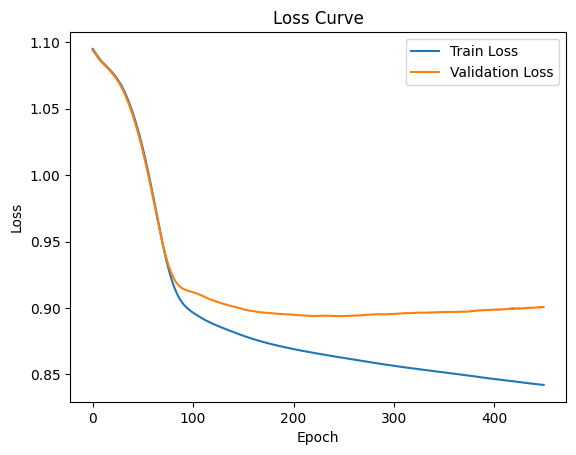

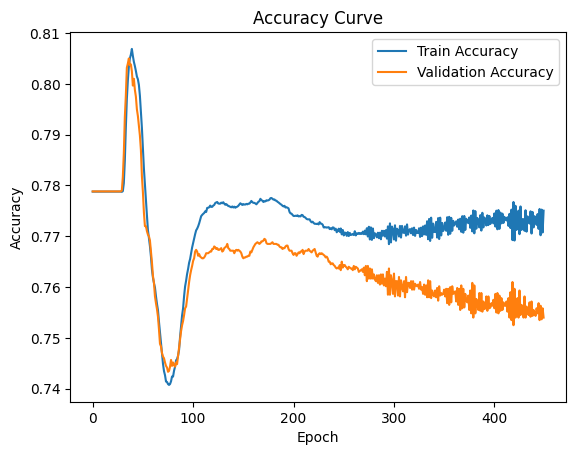

In [316]:
import matplotlib.pyplot as plt

# Loss
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

# Accuracy
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


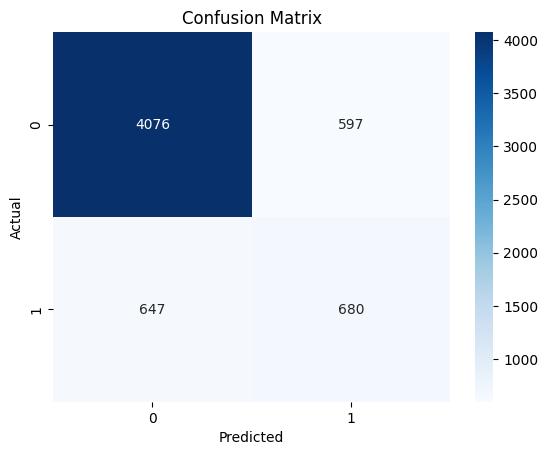

In [317]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


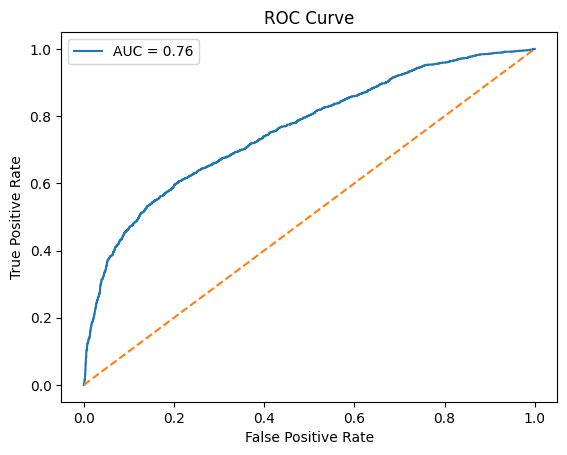

In [318]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


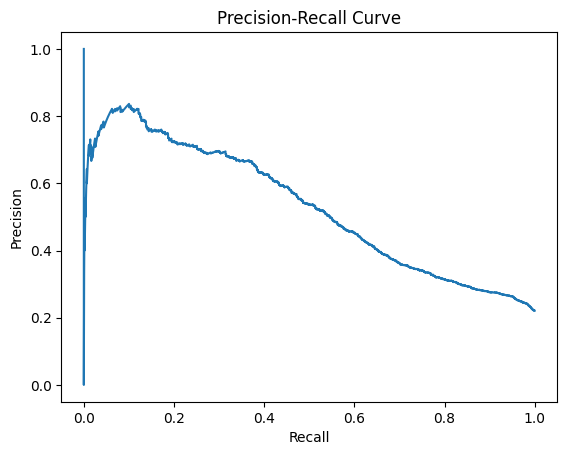

In [319]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_probs)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()
